In [1]:
import pandas as pd
import numpy as np

In [24]:
data = pd.read_csv('data_final_5d.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,Release Date,Period End,EPS,Forecast,Revenue,Forecast.1,ticker,Cash and cash equivalents,...,4d_after_open,4d_after_high,4d_after_low,4d_after_close,4d_after_volume,5d_after_open,5d_after_high,5d_after_low,5d_after_close,5d_after_volume
0,0,0,2020-02-20,2019-12-01,--,0.28,--,968.66M,VTR,0.0,...,0.00,0.0000,0.00,0.00,0.0,0.00,0.00,0.0000,0.00,0.0
1,1,1,2019-10-25,2019-09-01,0.23,0.32,983.16M,931.93M,VTR,148063000.0,...,65.21,65.7100,64.63,65.10,2122092.0,65.12,65.30,63.1488,64.03,2114593.0
2,2,2,2019-07-26,2019-06-01,0.58,0.32,950.72M,922.96M,VTR,81987000.0,...,67.33,67.9500,66.51,67.67,2069256.0,67.76,69.18,67.7600,68.83,1749714.0
3,3,3,2019-04-26,2019-03-01,0.35,0.3,942.87M,911.1M,VTR,82514000.0,...,61.23,61.9900,60.96,61.53,2198358.0,61.75,62.58,61.4650,62.48,1767991.0
4,4,4,2019-02-08,2018-12-01,0.17,0.35,923.26M,909.59M,VTR,72277000.0,...,64.29,64.9236,64.02,64.74,2043458.0,64.98,65.25,64.6400,65.21,1925856.0


## General

In [25]:
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.lower()

data.rename(columns={"forecast": "eps_forecast", 
                     "forecast.1": "revenue_forecast"}, 
            inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10663 entries, 0 to 10662
Columns: 177 entries, release_date to 5d_after_volume
dtypes: float64(170), object(7)
memory usage: 14.4+ MB


DataFrame consists of 7 object-type columns, let's look on them.

In [26]:
data.select_dtypes(include='object').head()

,release_date,period_end,eps,eps_forecast,revenue,revenue_forecast,ticker
0,2020-02-20,2019-12-01,--,0.28,--,968.66M,VTR
1,2019-10-25,2019-09-01,0.23,0.32,983.16M,931.93M,VTR
2,2019-07-26,2019-06-01,0.58,0.32,950.72M,922.96M,VTR
3,2019-04-26,2019-03-01,0.35,0.3,942.87M,911.1M,VTR
4,2019-02-08,2018-12-01,0.17,0.35,923.26M,909.59M,VTR


In [27]:
def replace_sign(x):
    if x[-1] == 'B':
        return float(x[:-1])*1e9
    if x[-1] == 'M':
        return float(x[:-1])*1e6

cols_date = ['release_date', 'period_end']
data.loc[:, cols_date] = data[cols_date].apply(pd.to_datetime, 
                                    format='%Y-%m-%d %H:%M:%S.%f')

revenue = ['revenue_forecast', 'revenue']
data[revenue] = data[revenue].apply(lambda x: x.str.replace(',',''))
data[revenue[0]] = data[revenue[0]].apply(replace_sign)
data[revenue[1]] = data[revenue[1]].apply(replace_sign)

eps = ['eps_forecast', 'eps']
eps_idxs = data[data[eps[0]] == '--'].index
epsf_idxs = data[data[eps[1]] == '--'].index
bad_idxs = eps_idxs.append(epsf_idxs)
data.drop(bad_idxs, inplace=True)

data[revenue + eps] = data[revenue + eps].apply(pd.to_numeric, errors='coerce')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10144 entries, 1 to 10662
Columns: 177 entries, release_date to 5d_after_volume
dtypes: datetime64[ns](2), float64(174), object(1)
memory usage: 13.8+ MB


## Handling zero values

As out data is not pure and was scraped from various data sources, there is many missing and zero values. During training all features have to be floats or chars, not NaN. The abundance of zeros is another problem, because in many cases this is not informative (due to common practice replacing NaN values with zeros) makes it harder and longer to train a model.

In [28]:
def trouble_df(df):
    zeros = df.isin([0]).sum()*100/data.shape[0]
    nans = df.isna().sum()*100/data.shape[0]
    trouble_vals = pd.concat((zeros.rename('zero_values, %'), 
                              nans.rename('NaN_values, %')), axis=1)
    return trouble_vals

In [29]:
trouble_vals = trouble_df(data)
zeros = trouble_vals.sort_values(by='zero_values, %', 
                         ascending=False)
zeros.head(10)

,"zero_values, %","NaN_values, %"
net_cash/marketcap,97.643927,0.000000
other_assets,95.001972,0.374606
deposit_liabilities,86.080442,0.009858
r&d_expense_growth,74.043770,0.088722
r&d_to_revenue,73.698738,0.088722
acquisitions_and_disposals,71.332808,0.019716
deferred_revenue,61.080442,0.009858
long-term_investments,54.593849,0.384464
tax_assets,44.489353,0.009858
tax_liabilities,43.099369,0.009858


Let's look on the columns. 0 dividend payments could be helpful values too. Other features seem to be less important or their values could be calculated having some base features

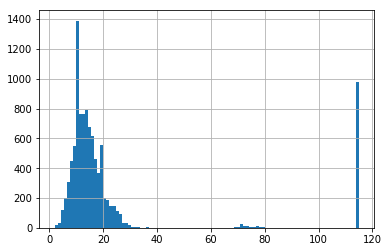

In [30]:
# all fundamental features
fundamentals = data.columns.tolist()[7:122]
zeros_in_rows = data[fundamentals].isin([0]).sum(axis=1).sort_values()
zeros_in_rows.hist(bins=100)

Drop that rows with large number of zeros in fundamental features.

In [31]:
idxs_many_zeros = zeros_in_rows[zeros_in_rows > 40].index
data.drop(idxs_many_zeros, inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(9049, 177)

First we drop columns with very high rate (let it be 30%) of zero values. Then it's worth to drop all rows where prices are zero, because in this case we couldn't label data for machine learning models.

In [33]:
to_drop_potential = zeros[zeros['zero_values, %'] > 30].index
to_drop_potential

Index(['net_cash/marketcap', 'other_assets', 'deposit_liabilities',
       'r&d_expense_growth', 'r&d_to_revenue', 'acquisitions_and_disposals',
       'deferred_revenue', 'long-term_investments', 'tax_assets',
       'tax_liabilities', 'inventories', 'ptb_ratio', 'inventory_growth',
       'effect_of_forex_changes_on_cash', 'average_inventory',
       'other_comprehensive_income', 'dividends_per_share_growth',
       'short-term_investments', 'investment_purchases_and_sales',
       'stock-based_compensation_to_revenue', 'issuance_(repayment)_of_debt'],
      dtype='object')

In [34]:
data.drop(to_drop_potential, axis=1, inplace=True)
data.shape

(9049, 156)

In [59]:
cols = data.columns.tolist()
price_related = cols[cols.index('5d_before_open'):]
sub_df = data[price_related][data['5d_before_open'] == 0]
sub_df.eq(0).sum(axis=1)

936     55
1018    55
1019    55
1020    55
1021    55
1022    55
1023    55
1024    55
1025    55
1026    55
1027    55
1028    55
1029    55
1030    55
1031    55
1032    55
1033    55
1034    55
1035    55
1036    55
1037    55
2392    55
3347    55
3544    55
3632    55
4695    55
4696    55
4697    55
4698    55
4699    55
4700    55
5880    55
5881    55
5882    55
5883    55
5884    55
5885    55
5886    55
5887    55
5888    55
5889    55
5890    55
5891    55
5892    55
5893    55
5894    55
5895    55
7721    55
7902    55
dtype: int64

As we can see if at least one price is missed in a row, the row doesn't have price information at all!

In [64]:
zeros_idxs = sub_df.index
zeros_idxs

Int64Index([ 936, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
            1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 2392,
            3347, 3544, 3632, 4695, 4696, 4697, 4698, 4699, 4700, 5880, 5881,
            5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892,
            5893, 5894, 5895, 7721, 7902],
           dtype='int64')

For some indexes there is no any price information at all. In this case we couldn't just fill them with reasonable prices. For other tickers where only a few price-related rows were missed we could find approximate prices from nearest releases for particular company.

In [65]:
# handling single missings
def find_price(df, idx, cols):
    """
    cols - names of price-related columns in df
    idx - index of row where prices are missed
    """
    # first we check last release for particular company
    if df.loc[idx + 1,:]['ticker'] == df.loc[idx,:]['ticker']:
        df.loc[idx, cols] = df.loc[idx + 1, cols]
    # if there is no relevant information in the past
    # we "see the future" and choose most relevant information 
    if df.loc[idx - 1,:]['ticker'] == df.loc[idx,:]['ticker']:
        df.loc[idx, cols] = df.loc[idx - 1, cols]
    return df

single_missings = np.array([936, 2392, 3347, 3544, 3632, 7721, 7902])
for idx in single_missings:
    data = find_price(data, idx, price_related)

# handling multiple missings
to_drop = set(zeros_idxs) - set(single_missings)
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)

## Handling missing values

In [68]:
trouble_vals = trouble_df(data)
nans = trouble_vals.sort_values(by='NaN_values, %', 
                                ascending=False)
nans.head(10)

,"zero_values, %","NaN_values, %"
weighted_average_shares_diluted_growth,1.310092,20.217609
current_ratio,0.000000,18.974131
working_capital,0.011102,18.974131
net_debt_to_ebitda,0.011102,15.565671
net_current_asset_value,0.011102,15.388032
revenue,0.000000,2.942156
ev_to_operating_cash_flow,0.000000,0.566226
graham_net-net,0.011102,0.566226
ev_to_free_cash_flow,0.000000,0.566226
ev_to_sales,0.000000,0.566226


Drop top 5 columns with highest rate of nan values, because it's unlikely we can reliably fill so much values.

In [69]:
many_nans_cols = nans.iloc[:5].index
data.drop(many_nans_cols, axis=1, inplace=True)

In my point of view Revenue is quate an important feature, so we don't want to lose it. Let's fill it with nearest not-null value for each company.

In [70]:
data[data['revenue'].isna()].head()

,release_date,period_end,eps,eps_forecast,revenue,revenue_forecast,ticker,cash_and_cash_equivalents,cash_and_short-term_investments,goodwill_and_intangible_assets,...,4d_after_open,4d_after_high,4d_after_low,4d_after_close,4d_after_volume,5d_after_open,5d_after_high,5d_after_low,5d_after_close,5d_after_volume
22,2014-04-25,2014-03-01,0.41,0.40,NaN,7.255600e+08,VTR,5.979100e+07,5.979100e+07,0.000000e+00,...,65.99,66.6500,65.7300,66.64,1448600.0,66.36,66.58,65.99,66.54,1430400.0
100,2014-07-14,2014-06-01,1.24,1.05,NaN,1.893400e+10,C,3.526800e+10,3.526800e+10,2.978900e+10,...,49.49,49.8100,49.3100,49.56,15453900.0,49.16,49.47,49.07,49.35,10920200.0
180,2016-05-02,2016-03-01,0.57,0.52,NaN,NaN,L,3.080000e+08,4.056300e+10,0.000000e+00,...,39.56,39.8300,39.5050,39.66,922231.0,39.57,39.76,39.41,39.42,926435.0
183,2015-08-03,2015-06-01,0.58,0.70,NaN,NaN,L,2.490000e+08,4.009900e+10,0.000000e+00,...,37.86,38.1400,37.8401,37.94,1447072.0,38.15,39.05,38.11,39.05,2021663.0
184,2015-05-04,2015-03-01,0.59,0.75,NaN,NaN,L,2.710000e+08,4.085400e+10,0.000000e+00,...,41.48,41.5675,41.1100,41.42,1044174.0,41.37,41.42,41.02,41.15,1334399.0


In [71]:
tickers_nans = data[pd.isnull(data).any(axis=1)]['ticker'].unique()
for ticker in tickers_nans:
    data[data['ticker'] == ticker] = data[data['ticker'] == ticker].ffill()

In [72]:
idxs = data[pd.isnull(data).any(axis=1)].index
idxs

Int64Index([ 166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,
             177,  178,  179,  180,  181,  182,  183,  184,  185,  186,  187,
             467, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332,
            1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343,
            1344, 4323, 4963, 4964, 4965, 4966, 4967, 5534, 5535, 5536, 5537,
            5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548,
            5549, 5550, 5551, 5552, 5553, 5554, 5937, 5938, 5939, 8781, 8782,
            8783],
           dtype='int64')

Now there are about 80 rows with nan values which is less than 1% of an entire dataset. During modelling step I want to replace values in rows with percentage change during the time between report releases. If we replace nan with zeros, it could produce unreliable percentage changes (say, 10000 in assets of this year and 0 in assets last year would lead to infinite change in assets, because we filled nan with 0), so it's much better to drop this rows than inventing a wheel.

In [74]:
data.drop(idxs, inplace=True)
data.reset_index(drop=True, inplace=True)

## Remove correlation 

Let's remove correlated fundamental features. First of all, create correlation matrix for any particular company and assume that correlation between columns preserves at the same level for all other companies.

In [77]:
all_features = data.columns.tolist()
first = all_features.index('ticker') + 1
last = all_features.index('5d_before_open')
fundamentals = all_features[first:last]

min_q = 9999
min_ticker = data['ticker'][0]
for i in data['ticker'].unique():
    cur_q = data[data['ticker'] == i].isin([0]).sum().sum()
    if cur_q < min_q:
        min_q = cur_q
        min_ticker = i

cor_mat = data[data['ticker'] == min_ticker].loc[:, fundamentals].corr().abs()
cor = cor_mat.unstack()
cor = cor[cor < 1].sort_values(kind="quicksort", ascending=False)
cor

shareholders_equity_per_share    book_value_per_share               1.000000
book_value_per_share             shareholders_equity_per_share      1.000000
-_cash_&_cash_equivalents        cash_per_share                     0.999973
cash_and_cash_equivalents        cash_per_share                     0.999973
cash_per_share                   -_cash_&_cash_equivalents          0.999973
                                 cash_and_cash_equivalents          0.999973
eps_growth                       eps_diluted_growth                 0.999602
eps_diluted_growth               eps_growth                         0.999602
pocf_ratio                       pfcf_ratio                         0.999600
pfcf_ratio                       pocf_ratio                         0.999600
stock_price                      market_capitalization              0.999526
market_capitalization            stock_price                        0.999526
ev_to_operating_cash_flow        ev_to_free_cash_flow               0.999486

As it common in finance, lots of features are highly correlated.

In [85]:
upper = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['cash_and_short-term_investments',
 'receivables',
 'total_assets',
 'total_current_assets',
 'total_debt',
 'total_liabilities',
 'total_non-current_assets',
 'total_non-current_liabilities',
 'total_shareholders_equity',
 'dividend_payments',
 'net_cash_flow_/_change_in_cash',
 'operating_cash_flow',
 '+_total_debt',
 '-_cash_&_cash_equivalents',
 'enterprise_value',
 'market_capitalization',
 'stock_price',
 'book_value_per_share',
 'cash_per_share',
 'debt_to_assets',
 'debt_to_equity',
 'ev_to_free_cash_flow',
 'ev_to_operating_cash_flow',
 'ev_to_sales',
 'earnings_yield',
 'enterprise_value_over_ebitda',
 'free_cash_flow_yield',
 'graham_number',
 'interest_coverage',
 'interest_debt_per_share',
 'invested_capital',
 'market_cap',
 'operating_cash_flow_per_share',
 'pb_ratio',
 'pe_ratio',
 'pfcf_ratio',
 'pocf_ratio',
 'price_to_sales_ratio',
 'revenue_per_share',
 'sg&a_to_revenue',
 'shareholders_equity_per_share',
 'tangible_asset_value',
 'tangible_book_value_per_share',
 

In [86]:
data.drop(to_drop, axis=1, inplace=True)
data.shape

(8929, 102)

In [87]:
data.to_csv('data/processed/processed_data.csv', index=False)